# __Tesi di Laurea – Visualizzazione spettrale dei grafi__

L’obiettivo è usare l'algebra spettrale per rappresentare graficamente la struttura di un grafo, sfruttando le informazioni che si ottengono dagli autovettori delle principali matrici associate al grafo (Laplaciana, normalizzata, Walk matrix, ecc.).

A seconda del tipo di grafo (orientato o meno), vengono fatte alcune ipotesi:
- Se il grafo è **non orientato**, si assume che sia **connesso**; altrimenti si lavora sulla componente connessa più grande.
- Se il grafo è **orientato**, si richiede che sia **fortemente connesso**, così da poter calcolare correttamente il **vettore di Perron** e costruire la **Laplaciana simmetrizzata** (secondo l’approccio di Chung).

Nel notebook si possono:
- caricare grafi da file (in formato `.json`)
- scegliere la matrice spettrale da usare
- calcolare autovalori e autovettori
- visualizzare il grafo in 1D o 2D usando gli autovettori come coordinate

Le funzioni sono state organizzate in modo modulare, per poter riutilizzare lo stesso codice con grafi diversi e con diversi tipi di rappresentazione.

## <hr style="border: 2px solid; margin-top: 15px;">
### __Librerie__

_Requisiti_

```
pip3 install -r requirements.txt
```

In [21]:
#!pip3 install numpy networkx matplotlib ipympl notebook
import numpy as np
import json 
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
np.set_printoptions(linewidth=250)

## <hr style="border: 2px solid; margin-top: 15px;">
### __Funzioni Ausiliarie__

### 
`ensure_connected(G)` si assicura che il grafo sia: 
1. connesso nel caso dei non orientati 
2. fortemente connesso nel caso degli orientati

In [22]:
def ensure_connected(G):
    if G.is_directed():
        if not nx.is_strongly_connected(G):
            G = G.subgraph(max(nx.strongly_connected_components(G), key=len)).copy()
    else:
        if not nx.is_connected(G):
            G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    mapping = {old: new for new, old in enumerate(sorted(G.nodes()))}
    return nx.relabel_nodes(G, mapping)

###
`compute_directed_eig(G)`

1. Estrae da `G` la matrice di adiacenza `A`.  
2. Calcola per ogni nodo la somma degli archi in uscita (`degree`).  
3. Divide ogni riga di `A` per il grado corrispondente, ottenendo `P` (probabilità di passare da un nodo a un altro).  
4. **Autovettore di Perron**: Risolve `P.T * x = x` e ottiene il primo autovettore (`phi`), poi lo normalizza in modo che la somma sia 1.  
5. Crea matrici diagonali con la radice quadrata di `phi` (`Phi_sqrt`) e l’inverso della radice quadrata (`Phi_inv_sqrt`).  
6. **Matrice Laplaciana**: Crea la matrice Laplaciana: ***L = I - 0.5 • (Phi^1/2 • P • Phi^-1/2 + Phi^-1/2 • P.T • Phi^1/2)***.

In [23]:
def compute_directed_eig(G, weight= None):
    
    A = nx.to_numpy_array(G, weight=weight)
    degree = A.sum(axis=1)                       # somma gradi in uscita per ogni nodo
    P = A / degree[:, None]                      # ogni riga viene normalizzata per il grado uscente di quel nodo
    
    # Calcolo del vettore di Perron (distribuzione stazionaria)
    eigvals, eigvecs = np.linalg.eig(P.T)
    idx = np.argmax(np.isclose(eigvals.real, 1))   # eigenvalue più vicino a 1
    phi = np.abs(eigvecs[:, idx].real)             # moduli -> positivo
    phi /= phi.sum()                               # normalizza

    Phi_sqrt = np.diag(np.sqrt(phi))
    Phi_inv_sqrt = np.diag(1 / np.sqrt(phi))

    L = np.identity(len(G)) - 0.5 * (Phi_sqrt @ P @ Phi_inv_sqrt + Phi_inv_sqrt @ P.T @ Phi_sqrt)
    vals, vecs = np.linalg.eigh(L)
    
    return vals, np.real(vecs), G

###
`compute_eig(G, mat_type)`

1. **Connettività**  
   Verifica che il grafo sia connesso, con `ensure_connected(G)`.

2. **Grafi diretti**  
   Se il grafo è diretto e `mat_type == "laplacian"`, delega il calcolo a `compute_directed_eig(G)`.

3. **Grafi non diretti**  
   - **Matrice di adiacenza**: Converte il grafo in una matrice `A`.
   - **Vettore dei gradi**: Calcola `degrees` sommando gli archi in ogni riga di `A`.
   - **Matrice D**: Crea una matrice diagonale `D` con i gradi.
   - **Calcola gli autovettori**: a seconda del `mat_type` scelto calcola gli autovettori della matrice scelta (Laplaciana, Laplaciana normalizzata, Walk matrix, Lazy Walk matrix ecc.)

In [24]:
# ----------- Funzioni di calcolo per grafi non diretti -----------
# In un grafo non diretto, Laplaciani (normali/normalizzati) sono simmetrici => autovalori reali. 
# Walk e lazywalk no => possibili parti immaginarie Walk normalizzata si simmetrizza (->autovalori reali)
def _laplacian(A, D):
    L = D - A
    return np.linalg.eigh(L)  # np.linalg.eigh -> matrice simmetrica, autovalori reali

def _laplacian_normalized(A, D, D_inv_sqrt):
    L = D_inv_sqrt @ (D - A) @ D_inv_sqrt
    return np.linalg.eigh(L)

def _walk(A, D_inv):
    W = A @ D_inv
    vals, vecs = np.linalg.eig(W)
    return vals, np.real(vecs)  

def _lazywalk(A, D_inv, I):
    W = A @ D_inv
    M = 0.5 * (I + W)
    vals, vecs = np.linalg.eig(M)
    return vals, np.real(vecs)

def _walknorm(A, D_inv, D_inv_sqrt, I):
    W = A @ D_inv
    M = 0.5 * (I + W)
    N = D_inv_sqrt @ M @ D_inv_sqrt
    return np.linalg.eigh(N)

In [25]:
def compute_eig(G, mat_type="laplacian", weight=None):

    G = ensure_connected(G)
    
    # Caso grafo diretto
    if G.is_directed():
        if mat_type == "laplacian":
            return compute_directed_eig(G, weight=weight)
        else:
            raise ValueError(f"mat_type '{mat_type}' non supportato su grafo diretto")
    
    # Qui: G è non diretto
    A = nx.to_numpy_array(G, weight=weight)
    degrees = A.sum(axis=1)

    if np.any(degrees == 0):
        raise ValueError("Ci sono nodi di grado 0; il grafo non dovrebbe essere connesso?")

    # Matrici di grado
    D = np.diag(degrees)
    D_inv = np.diag(1 / degrees)
    D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
    I = np.eye(len(G))
    
    # Switch dei calcoli
    matrix_type_switch = {
        "laplacian": lambda: _laplacian(A, D),
        "normalized": lambda: _laplacian_normalized(A, D, D_inv_sqrt),
        "walk": lambda: _walk(A, D_inv),
        "lazywalk": lambda: _lazywalk(A, D_inv, I),
        "walknorm": lambda: _walknorm(A, D_inv, D_inv_sqrt, I)
    }
    
    # Se il tipo non è presente, errore
    if mat_type not in matrix_type_switch:
        raise ValueError(f"Tipo di matrice '{mat_type}' non supportato")
    
    vals, vecs = matrix_type_switch[mat_type]()

    return vals, vecs, G

### Funzioni di Visualizzazione

Le tre funzioni seguenti permettono di rappresentare visivamente i grafi sulla base dei loro autovettori spettrali.

- `plot_line(G, mat_type, title)` → visualizza un autovettore alla volta (1D)
- `plot_2d(G, mat_type, x, y, title)` → visualizza i nodi in 2D usando due autovettori come coordinate, con possibilità di selezionare dinamicamente quali
- `plot_3d(G, mat_type, x, y, z, title)` → visualizza i nodi in 3D usando tre autovettori come coordinate, con possibilità di selezionare dinamicamente quali

Entrambe le funzioni calcolano internamente la matrice scelta tramite `compute_eig`, e poi disegnano il grafo.

###
Plot 1D

In [26]:
def plot_line(G, mat_type="laplacian", title=""):
    # Calcola autovalori e autovettori
    vals, vecs, G = compute_eig(G, mat_type)
    
    # Crea figura e asse
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(title)
    
    # Array degli indici dei nodi (da 0 a n-1)
    xdata = np.arange(len(G))
    
    # Disegna il primo autovettore come linea con marker circolari
    line, = ax.plot(xdata, vecs[:, 0], marker='o', markersize=3, linewidth=1)
    
    # Crea area per lo slider
    slider_ax = plt.axes([0.2, 0.05, 0.6, 0.03])
    
    # Imposta lo slider: varia da 0 a len(G)-1, incremento di 1
    slider = Slider(slider_ax, "k", 0, len(G)-1, valinit=0, valstep=1)
    
    # Funzione di callback per aggiornare il grafico
    def update(_):
        k = int(slider.val)         # Indice selezionato
        line.set_ydata(vecs[:, k])  # Aggiorna i dati y con il k-esimo autovettore
        ax.relim()                  # Ricalcola i limiti dell'asse
        ax.autoscale_view()         # Aggiorna la scala
        fig.canvas.draw_idle()      # Ridisegna la figura
        
    slider.on_changed(update)
    
    # Ritorna la figura, l'asse, lo slider, gli autovalori, gli autovettori e il grafo aggiornato
    return fig, ax, slider, vals, vecs

###
Plot 2D

In [27]:
def plot_2d(G, mat_type="laplacian", x=0, y=1, title="", weight=None):
    # Calcola autovalori e autovettori, eventualmente considerando i pesi
    vals, vecs, G = compute_eig(G, mat_type, weight=weight)
    
    # Crea figura e asse
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title(title)
    
    # Calcola le posizioni dei nodi basate sugli autovettori scelti per le coordinate x e y
    pos = {i: (vecs[i, x], vecs[i, y]) for i in range(len(G))}
    nx.draw(G, pos=pos, with_labels=True, ax=ax, font_size=3,
            node_size=70, node_color="skyblue", arrows=True, arrowsize=7,
            edge_color="gray", width=0.15)
    
    # Crea le aree per gli slider
    sx_ax = plt.axes([0.2, 0.08, 0.65, 0.03])
    sy_ax = plt.axes([0.2, 0.03, 0.65, 0.03])
    
    # Crea gli slider per selezionare gli indici degli autovettori da usare per X e Y
    sx = Slider(sx_ax, "X", 0, len(G)-1, valinit=x, valstep=1)
    sy = Slider(sy_ax, "Y", 0, len(G)-1, valinit=y, valstep=1)
    
    # Callback per aggiornare la visualizzazione
    def update(_):
        ax.clear()
        xx = int(sx.val)
        yy = int(sy.val)
        new_pos = {i: (vecs[i, xx], vecs[i, yy]) for i in range(len(G))}
        nx.draw(G, pos=new_pos, with_labels=True, ax=ax, font_size=3,
                node_size=50, node_color="skyblue", arrows=True, arrowsize=7,
                edge_color="gray", width=0.15)
        ax.set_title(title)
        fig.canvas.draw_idle()
    
    sx.on_changed(update)
    sy.on_changed(update)
    
    # Ritorna la figura, l'asse, gli slider e gli autovalori/autovettori
    return fig, ax, (sx, sy), vals, vecs

### 
Plot 3D

In [ ]:
def plot_3d(G, mat_type="laplacian", x=0, y=1, z=2, title=""):
   
    vals, vecs, G = compute_eig(G, mat_type)
    
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    
   
    xs = vecs[:, x]
    ys = vecs[:, y]
    zs = vecs[:, z]
    
    # Disegno nodi
    scat = ax.scatter(xs, ys, zs, c='skyblue', s=50, edgecolors='k', depthshade=True)
    
    # Disegno archi
    lines_dict = {}
    for (u, v) in G.edges():
        xx = [xs[u], xs[v]]
        yy = [ys[u], ys[v]]
        zz = [zs[u], zs[v]]
        ln = ax.plot(xx, yy, zz, color='gray', linewidth=0.5)[0]
        lines_dict[(u, v)] = ln
    
    ax.set_xlabel("Autovettore X")
    ax.set_ylabel("Autovettore Y")
    ax.set_zlabel("Autovettore Z")

    
    text_labels = []

    # Funzione che pulisce i label
    def clear_labels():
        for lbl in text_labels:
            lbl.remove()  # elimina l'oggetto text dallo axes
        text_labels.clear()

    for i in range(len(G)):
        lbl = ax.text(xs[i], ys[i], zs[i], s=str(i), size=3, color="black")
        text_labels.append(lbl)
    
    Slider
    slider_ax_x = plt.axes([0.15, 0.07, 0.65, 0.03])
    slider_ax_y = plt.axes([0.15, 0.04, 0.65, 0.03])
    slider_ax_z = plt.axes([0.15, 0.01, 0.65, 0.03])
    
    x_slider = Slider(slider_ax_x, "X", 0, len(G)-1, valinit=x, valstep=1)
    y_slider = Slider(slider_ax_y, "Y", 0, len(G)-1, valinit=y, valstep=1)
    z_slider = Slider(slider_ax_z, "Z", 0, len(G)-1, valinit=z, valstep=1)
    
    def update(_):
        xx = int(x_slider.val)
        yy = int(y_slider.val)
        zz = int(z_slider.val)
        
        xs_new = vecs[:, xx]
        ys_new = vecs[:, yy]
        zs_new = vecs[:, zz]

        # Aggiorna scatter
        scat._offsets3d = (xs_new, ys_new, zs_new)
        
        # Aggiorna archi
        for (u, v), line3d in lines_dict.items():
            line3d.set_xdata([xs_new[u], xs_new[v]])
            line3d.set_ydata([ys_new[u], ys_new[v]])
            line3d.set_3d_properties([zs_new[u], zs_new[v]])
        
        # Riposiziona label: prima rimuoviamo i vecchi, poi li ricostruiamo
        clear_labels()
        for i in range(len(G)):
            lbl = ax.text(xs_new[i], ys_new[i], zs_new[i], s=str(i), size=3, color="black")
            text_labels.append(lbl)

        fig.canvas.draw_idle()
    
    x_slider.on_changed(update)
    y_slider.on_changed(update)
    z_slider.on_changed(update)
    
    plt.show()
    
    return fig, ax, (x_slider, y_slider, z_slider), vals, vecs

### 
`plot_from_file(path, mat_type, mode, x, y, z, title)`

**Carica un grafo da file `.json` e richiama automaticamente la visualizzazione spettrale.**  
Permette di selezionare il tipo di matrice (`laplacian`, `normalized`, ecc.) e se visualizzarlo in 1D, 2D, 3D (tramite `mode="1d"`, `mode="2d"` o `mode="3d"`).  
Richiede solo il nome del file del grafo, nel formato node-link.

In [29]:
def plot_from_file(path, mat_type="laplacian", mode="2d", x=None, y=None, z=None, title=None, weight=None):
    with open(path) as f:
        data = json.load(f)
    G = nx.node_link_graph(data)

    if mode == "3d":
        return plot_3d(G, mat_type=mat_type, x=x, y=y, z=z, title=title)
    if mode == "2d":
        return plot_2d(G, mat_type=mat_type, x=x, y=y, title=title, weight=weight)
    elif mode == "1d":
        return plot_line(G, mat_type=mat_type, title=title)

## <hr style="border: 2px solid; margin-top: 15px;">
###  __Esempi di utilizzo__

In questa sezione vengono mostrati alcuni esempi pratici di visualizzazione spettrale su grafi semplici e complessi.

L’obiettivo è verificare come le varie matrici (Laplaciana, normalizzata, walk matrix, ecc.) influenzano la rappresentazione dei nodi nel piano.

Gli esempi sono divisi per tipologia:
- Grafi noti e regolari (cammino, dodecaedro, griglia)
- Grafi casuali non orientati e orientati
- Grafi caricati da file `.json`

### 1. Cammino di 12 nodi

Costruzione di un cammino (path) di 12 nodi. Viene visualizzato un grafico a linea degli autovettori con uno slider per selezionare l’indice k.

In [ ]:
G1 = nx.path_graph(12)
fig, ax, slider, vals, vecs = plot_line(G1, mat_type="laplacian", title="Cammino di 12 nodi")
# plt.close(fig)

### 2. Dodecaedro

Visualizzazione del dodecaedro usando la matrice Laplaciana.

NameError: name 'x_slider' is not defined

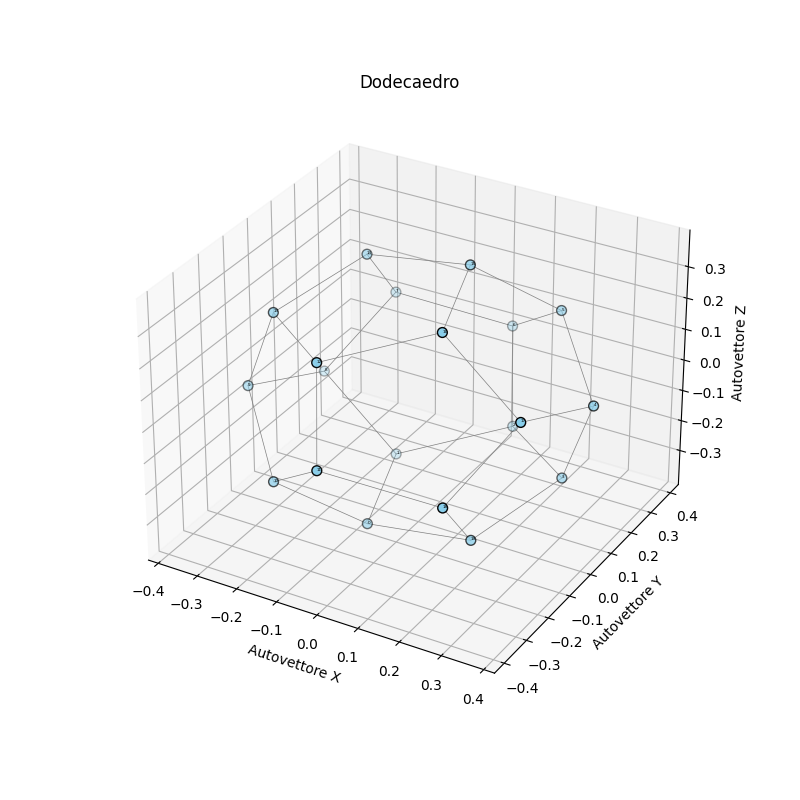

In [30]:
G2 = nx.dodecahedral_graph()
fig, ax, slider, vals, vecs = plot_3d(G2, mat_type="laplacian", x=1, y=2, z=3, title="Dodecaedro")

### 3. Grafi non orientati

#### 
3.1 Albero Casuale

Visualizzazione di un albero casuale con la Laplaciana.

In [ ]:
G3 = nx.random_tree(20)
fig, ax, slider, vals, vecs = plot_2d(G3, "laplacian", 1, 2, "Albero casuale")

In [ ]:
fig, ax, slider, vals, vecs = plot_3d(G3, "laplacian", 1, 2, 3, "Albero casuale")

#### 
3.2 Grafo Non Orientato Casuale

Genera un grafo casuale con 20 nodi e 30 archi (assicurandosi che sia connesso) e lo visualizza con la Laplaciana normalizzata.

In [ ]:
n = 15
m = 25
while True:
    G4 = nx.gnm_random_graph(n, m)
    if nx.is_connected(G4):
        break
fig, ax, slider, vals, vecs = plot_2d(G4, "normalized", 1, 2)

In [ ]:
fig, ax, slider, vals, vecs = plot_3d(G4, "normalized", 1, 2, 3)

#### 
3.3 Griglia 4x4

In [ ]:
G6 = nx.grid_2d_graph(4, 4)   # Crea una griglia 4x4
G6 = nx.convert_node_labels_to_integers(G6)  # Rinomina i nodi in interi consecutivi
fig, ax, slider, vals, vecs = plot_2d(G6, "laplacian", 1, 2, "Grid Graph")

In [ ]:
fig, ax, slider, vals, vecs = plot_3d(G6, "laplacian", 1, 2, 3, "Grid Graph")

####
3.4 Cubo

In [ ]:
G7 = nx.cubical_graph()
fig, ax, slider, vals, vecs = plot_3d(G7, "laplacian", 1, 2, 3, "Cubo")

####
3.5 Ipercubo

In [ ]:
G8 = nx.hypercube_graph(4)
fig, ax, slider, vals, vecs = plot_2d(G8, "walknorm", 1, 2, "Ipercubo")

In [ ]:
fig, ax, slider, vals, vecs = plot_3d(G8, "normalized", 1, 2, 3, "Ipercubo")

####
3.6 Grafo Casuale Regolare

In [ ]:
G9 = nx.random_regular_graph(d=4, n=20)
fig, ax, slider, vals, vecs = plot_2d(G9, "normalized", 1, 2, "Grafo casuale regolare")

### 4. Grafi orientati

Per grafi orientati viene usata la procedura con P e il vettore di Perron per calcolare la Laplaciana simmetrica.

In [ ]:
G5 = nx.gnp_random_graph(30, 0.3, directed=True)
fig, ax, slider, vals, vecs = plot_2d(G5, "laplacian", 1, 2)

### 5. Caricamento con JSON
Il grafo del logo di Yale mantiene una struttura regolare e simmetrica.

In [ ]:
fig, ax, _, _, _ = plot_from_file("graphs/yale_graph.json", mat_type="laplacian", mode="2d", x=1, y=2, weight="weight")       

In [ ]:
fig, ax, slider, vals, vecs = plot_from_file("graphs/yale_graph.json", "laplacian", mode="3d", x=1, y=2, z=3, weight="weight")